In [1]:
#importing dependencies
import datetime
import pandas as pd
import numpy as np
import os
from sklearn import preprocessing
import seaborn as sns
from PIL import Image
from IPython.display import Image
from keras.models import Sequential
from keras.layers import Dense,LSTM,GRU,SimpleRNN,Activation
from sklearn.metrics import mean_squared_error
import livelossplot
from keras_sequential_ascii import keras2ascii
from sklearn.cross_validation import train_test_split
from keras import optimizers,metrics
import pickle
from pandas import concat
from keras import losses
from keras import backend
import matplotlib.pyplot as plt
from keras.callbacks import History 
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from pylab import plot, show, savefig, xlim, figure,hold, ylim, legend, boxplot, setp, axes
from matplotlib.legend import Legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import itertools as it
import keyboard
plt.style.use('classic')
%config InlineBackend.figure_format = 'retina'
pylab.rcParams["font.size"] = "30"
%matplotlib inline
import warnings
import time


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
warnings.filterwarnings("ignore")

#Fnding possible combinations for 
#the under consideration activation funcitons
#based on the model layers (3-3 combinations considered as t a time)

In [3]:
possible_combinations=list(it.product(['softmax','sigmoid'],repeat=3))
# considered pairs are (sigmoid, relu) ,  (softmax,tanh) , (softplus,tanh), (softsign,tanh)


In [4]:


# each combination is run for 4 times to log the values in excel at the end
# we manually input the cobination in the model
# and run it with reset model variable
objective_function=['Adagrad','sgd','RMSprop']
loss_function=['mean_squared_error','cosine_proximity','cosine','hinge','kullback_leibler_divergence','logcosh','mean_absolute_error','mean_squared_logarithmic_error','poisson']
neurons_considered_layer1=['35','45','55','65']
neurons_considered_layer2=['3','5','10','15','20']


In [5]:
possible_combinations

[('softmax', 'softmax', 'softmax'),
 ('softmax', 'softmax', 'sigmoid'),
 ('softmax', 'sigmoid', 'softmax'),
 ('softmax', 'sigmoid', 'sigmoid'),
 ('sigmoid', 'softmax', 'softmax'),
 ('sigmoid', 'softmax', 'sigmoid'),
 ('sigmoid', 'sigmoid', 'softmax'),
 ('sigmoid', 'sigmoid', 'sigmoid')]

In [6]:
activation_index=7
index=6
loss_function[index] 
neurons_considered_layer1_index=3
neurons_considered_layer2_index=1
print(neurons_considered_layer1[neurons_considered_layer1_index])
print(neurons_considered_layer2[neurons_considered_layer2_index])
print(possible_combinations[activation_index])
print(loss_function[index])
print(objective_function[2])

65
5
('sigmoid', 'sigmoid', 'sigmoid')
mean_absolute_error
RMSprop


In [441]:
#resets the defined variables so they don't mess with the 
#next run with changed parameters to logg their performance.
#reseting the keras model variable and history variable

del lstm_fitted_model,history,a

#Loading Data

In [7]:
path=r"I:\personal\Laptop G\G laptop folder\My Projects\Jupyter\PhD Implemntation\Final Pre-processed Data"
os.chdir(path)

In [8]:
print(os.getcwd())

I:\personal\Laptop G\G laptop folder\My Projects\Jupyter\PhD Implemntation\Final Pre-processed Data


#reading links pickle stored data

In [9]:
with open('filtered_data(L1in,L2out,L3out).pickle', 'rb') as handle1:
    b = pickle.load(handle1)

#reading the corresponding timeseries data

In [10]:
with open('filtered_data(time).pickle', 'rb') as handle2:
    d = pickle.load(handle2)

#converting the read arrays to dataframes for better raedanility

In [11]:
df_b=pd.DataFrame(b,columns=['L1-in','L2-out','L3-out'])
df_d=pd.DataFrame(d,columns=['Interval'])

#merging the two datasets column wise

In [12]:
df = pd.concat([df_d, df_b], axis=1)
df.set_index('Interval',inplace=True)

#plotting for the first day of the dataset

#Sample Data Plot for 1st April

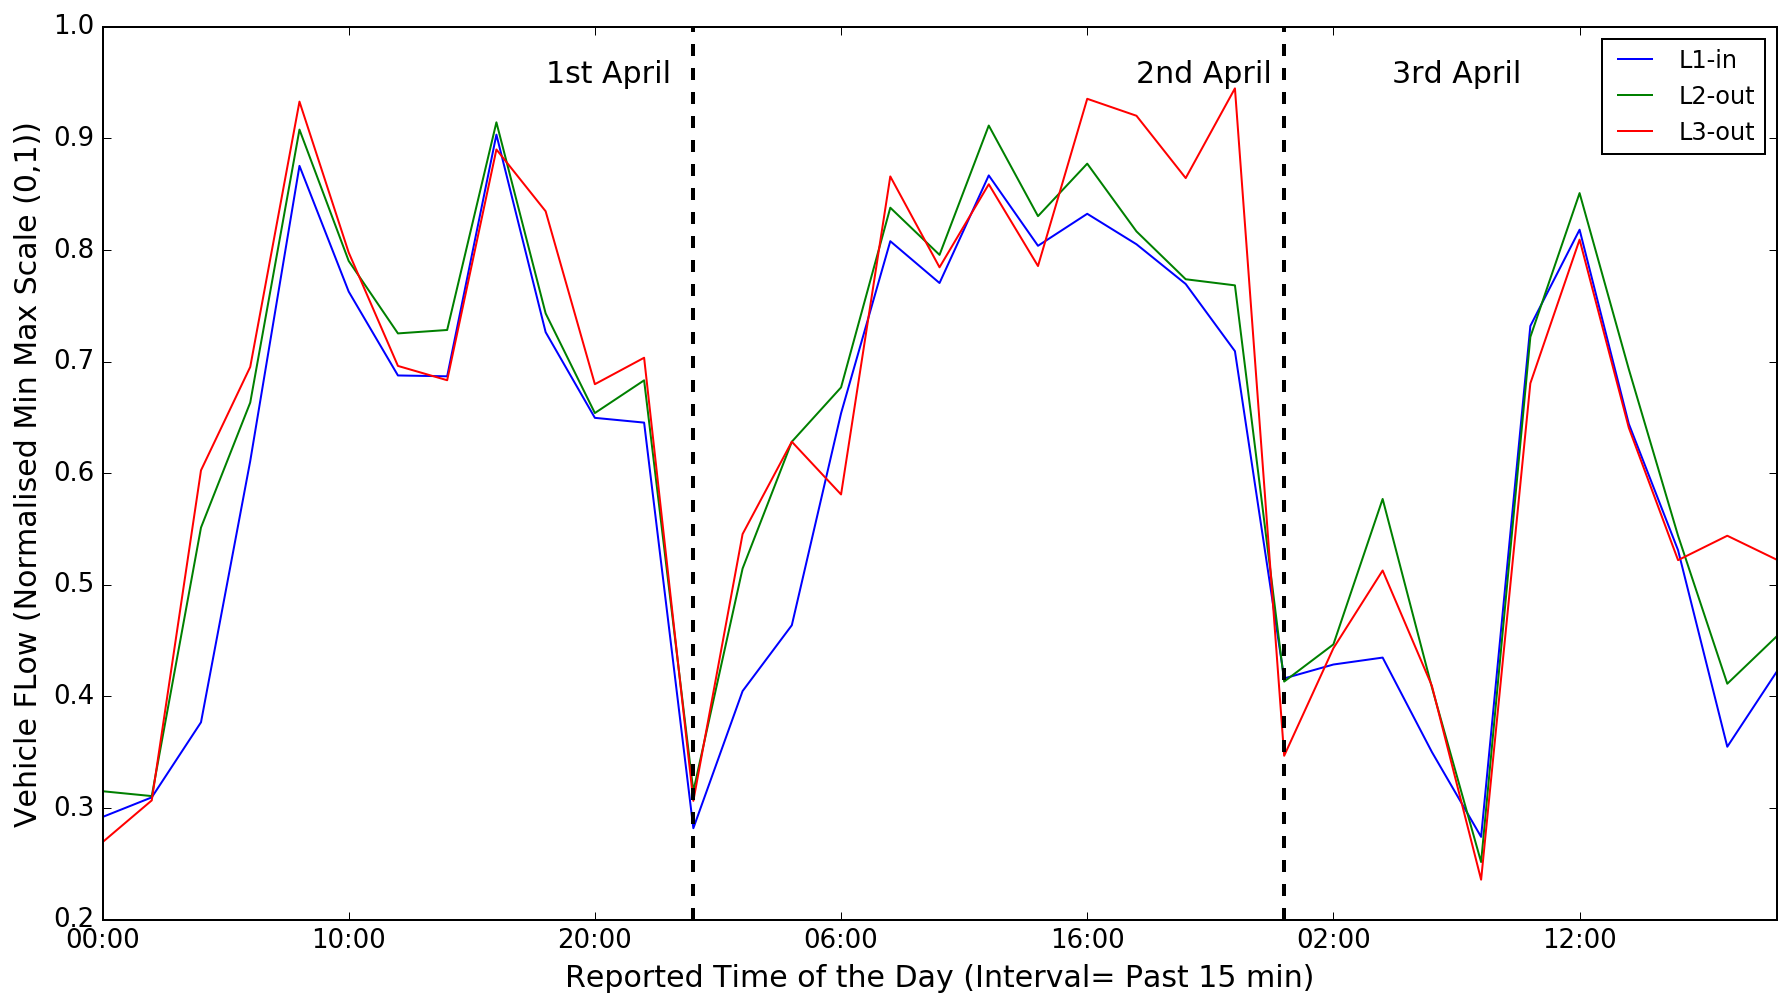

In [18]:
ax=df[0:35].plot(figsize=(15,8),kind='line',)
#df[0:30].plot(figsize=(15,8),kind='bar',ax=ax,sharex=True)

#day text
plt.text(x=9.,y=0.95,s='1st April',size=15,color='k')
plt.text(x=21.,y=0.95,s='2nd April',size=15,color='k')
plt.text(x=26.2,y=0.95,s='3rd April',size=15,color='k')
#vertical line
plt.axvline(x=24,color='k', linestyle='--',linewidth=2)
plt.axvline(x=12,color='k', linestyle='--',linewidth=2)

for p in ax.patches:
    valy = "{0:.2f}".format(round(p.get_height(),3))
    valx = "{0:.2f}".format(round(p.get_x(),2))
    
    ax.annotate(str(valy), (float(valx)*1.010 , float(valy) *1.010),size=7)
plt.legend(loc='left')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Reported Time of the Day (Interval= Past 15 min)',size=15)
plt.ylabel('Vehicle FLow (Normalised Min Max Scale (0,1))',size=15)
plt.savefig('Original_Dataset_Flow_profile_1st&2nd_April.png')

#Sample Data Plot for 31st Dec

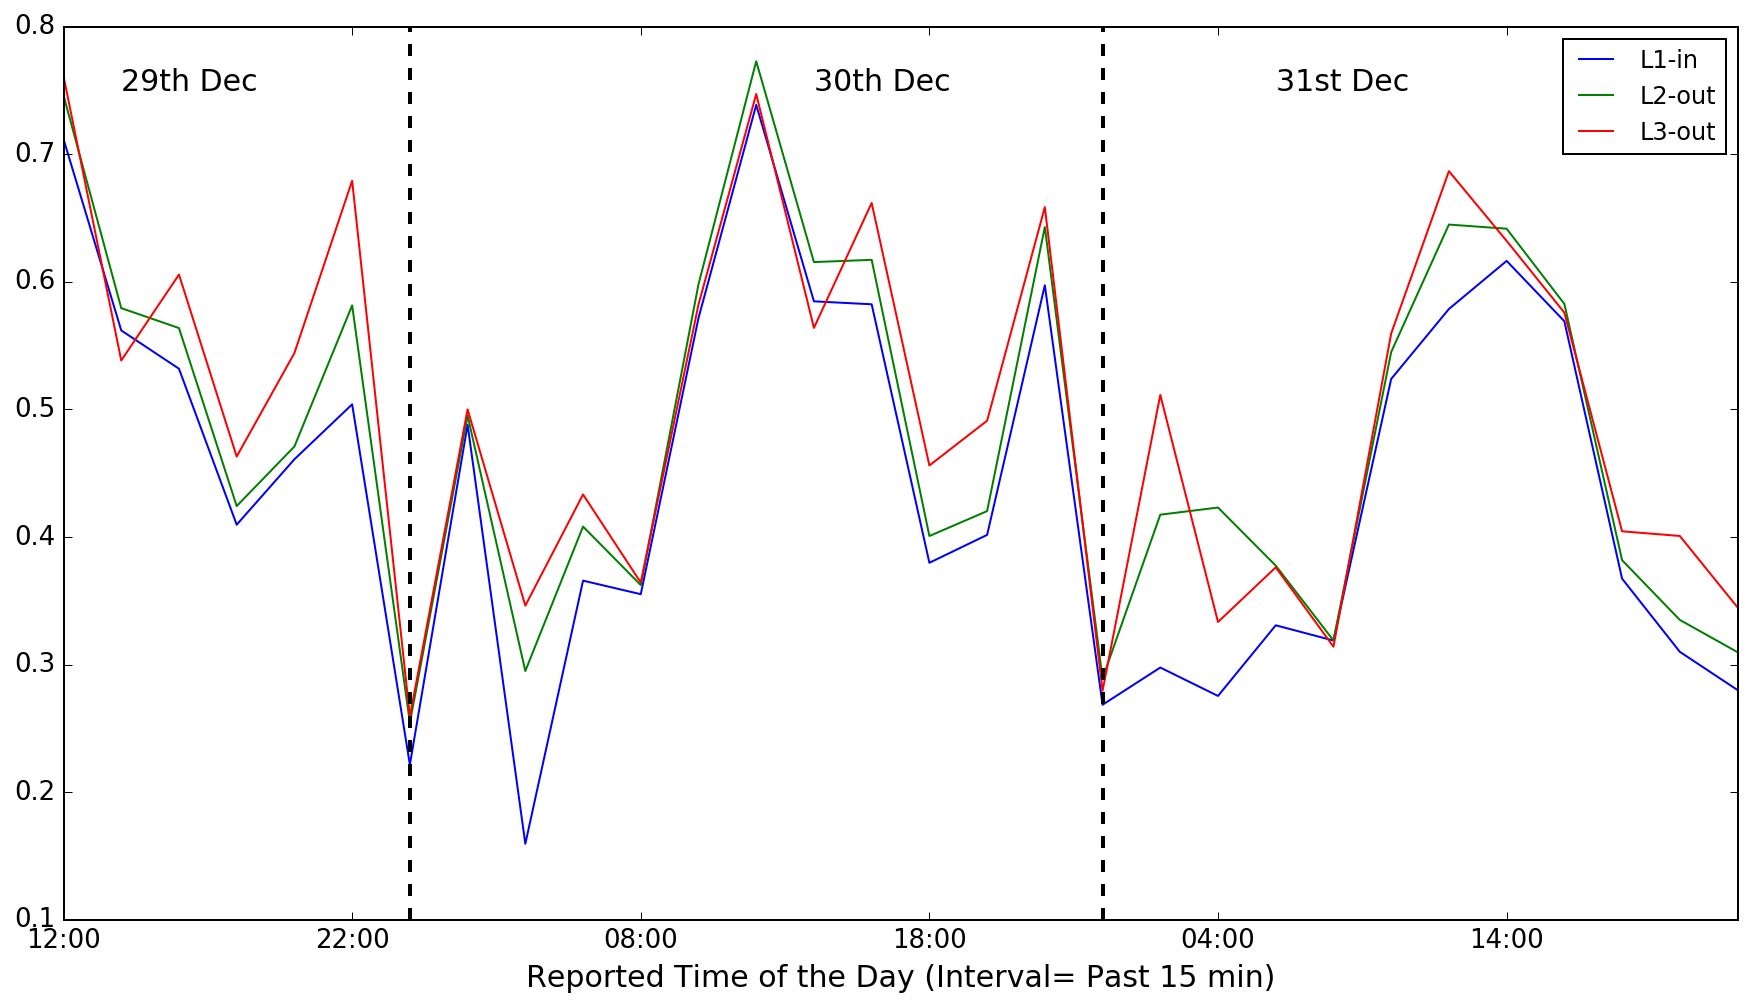

In [19]:
ax=df[3222:3252].plot(figsize=(15,8),kind='line',sharex=True)
#df[3222:3252].plot(figsize=(15,8),kind='bar',ax=ax)

#day text
plt.text(x=1.,y=0.75,s='29th Dec',size=15,color='k')
plt.text(x=13,y=0.75,s='30th Dec',size=15,color='k')
plt.text(x=21,y=0.75,s='31st Dec',size=15,color='k')

#vertical line

plt.axvline(x=6,color='k', linestyle='--',linewidth=2)
plt.axvline(x=18,color='k', linestyle='--',linewidth=2)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel('Reported Time of the Day (Interval= Past 15 min)',size=15)
#plt.ylabel('Vehicle FLow (Normalised Min Max Scale (0,1))',size=15)
plt.savefig('Original_Dataset_Flow_profile_30th&3st_Dec.png')

#sorting the data for LSTM
#converting the time series to a sequential supervised elarning problem

In [12]:
def sequence_to_supervised(data,lag=1):
    #already in dataframe so no need to convert it
    df=pd.DataFrame(data)
    columns=[df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df= concat(columns,axis=1)
    df.fillna(0,inplace=True)
    return df

#Final Scaling the data to Min Max in range (0,1)
#Althoug the data is already normalised

In [13]:

def MinMaxScaleFunc(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(data)
    return scaled

# Stacked LSTM (2 layers) 

#defining the model and training routine

In [442]:
# defing the learning rate and the keras plot library to visulise metrics
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.7, nesterov=False)
plot_losses = livelossplot.PlotLossesKeras()
history=History()

#A common error meaaure to be considered for model with 
#different parameters

In [14]:
def rmse(y_true, y_pred):
    
    #result.append(np.sqrt(np.mean(np.square(y_pred - y_true))))
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1)) 

In [443]:
def lstm_fit(train, batch_size, nb_epoch, neurons):
    
    X,y=train[:,0:3],train_data[:,3:6]
    X=X.reshape(X.shape[0],1,X.shape[1])
    model=Sequential()
    model.add(LSTM(int(neurons_considered_layer1[neurons_considered_layer1_index]),batch_input_shape=(batch_size,X.shape[1],X.shape[2]),activation=str(possible_combinations[activation_index][0]),
                   return_sequences=True,kernel_initializer='normal'))
    model.add(LSTM(int(neurons_considered_layer2[neurons_considered_layer2_index]),activation=str(possible_combinations[activation_index][1])))
    model.add(Dense(3))
    model.add(Activation(str(possible_combinations[activation_index][2])))
    model.compile(loss=loss_function[index],optimizer=objective_function[2], 
                  metrics=['accuracy',rmse])
    #for i in range(nb_epoch):
    model.fit(X, y,epochs=nb_epoch, batch_size=1, verbose=0, shuffle=False,
              validation_split=0.2,callbacks=[livelossplot.PlotLossesKeras(),history])
    #model.reset_states()
    return model   

  

#fitting the model with changing cost functions

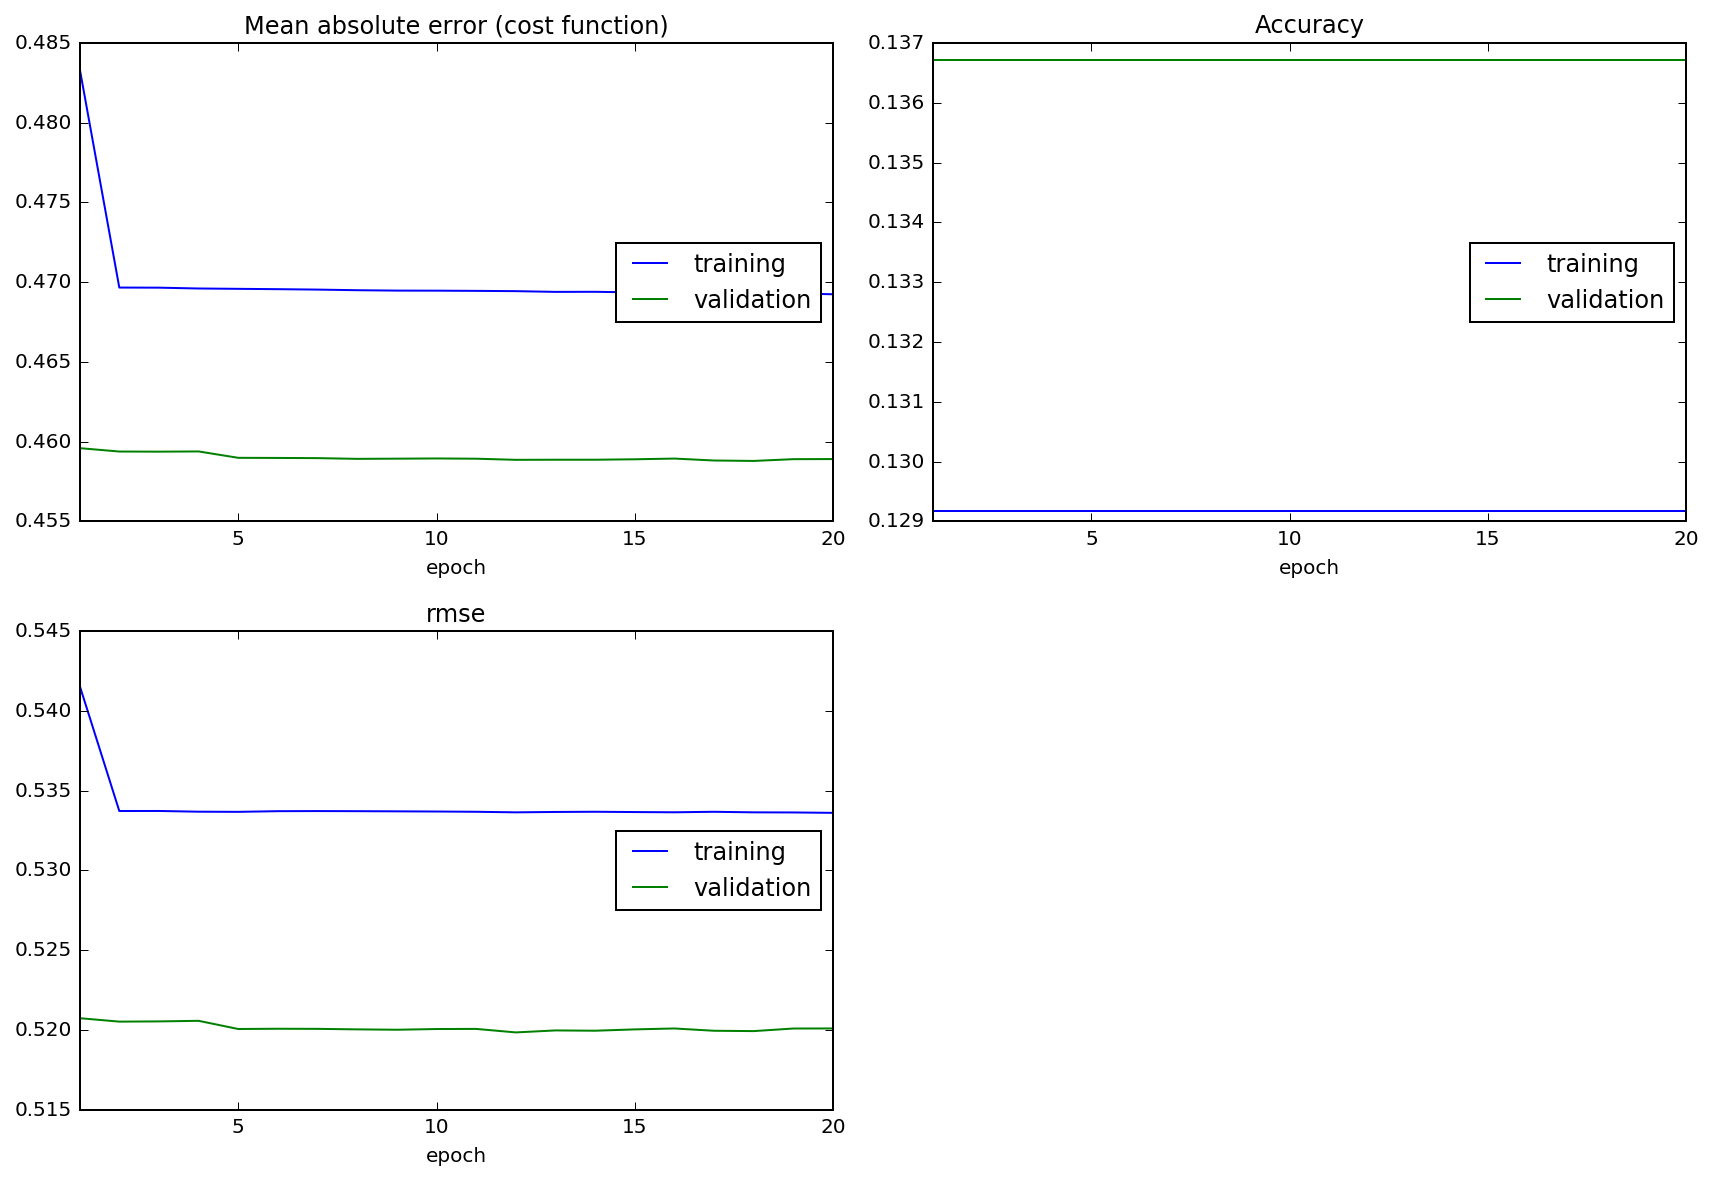

In [444]:
supervised_data=sequence_to_supervised(b,1)
######fetching just the values or arrays
supervised_data_values=supervised_data.values
# manually splitting the data into train and test data as the sequence matters
train_data,test_data=supervised_data_values,supervised_data_values[:,0:3]
#transforming the data with the scaling function [0,1] ---- MinMax Normalisation
train_data=MinMaxScaleFunc(train_data)
#created validation sets
########################################
################ fiting the model##########
lstm_fitted_model=lstm_fit(train_data, batch_size=1,nb_epoch=20, neurons=10)

In [ ]:
#saving the trained model
lstm_fitted_model.save('dummy.h5')

In [445]:
# predicitng for some test values from original dataset
test_data=supervised_data_values[:,0:3]
test_data=test_data.reshape(test_data.shape[0],1,test_data.shape[1])
lstm_fitted_model.predict(test_data,batch_size=1)[3251]


array([0.45124832, 0.        , 0.        ], dtype=float32)

In [446]:
test_data[3251]

array([[0.30997303, 0.33498147, 0.40078586]], dtype=float32)

#  Storing the Results

#storing the results everytime into series->dataframe->excel

In [447]:
a=history.history

In [448]:

# getting per epoch trained model history values
for i in a.keys():
    a[i]=np.mean(a[i],axis=0)




In [449]:
#converting a list to series
z = pd.Series(a,name=loss_function[index])

In [450]:
#series frame conversion after taking transpose
z= pd.DataFrame(z)

In [451]:
#taking transpose
z=z.T

#putting the dataframe values

In [ ]:

#rearranging the results dataframe columnwise-- copied the cell from above with addtional neurons and activation
# function logging.
z['Optimiser']=str(objective_function[2])
z['Epochs']=20
z['Neurons_L1']=45
z['Neurons_L2']=20
z['Avt_L1']='softmax'
z['Act_L2']='softmax'
z['Act_DL']='softmax'
z = z.reindex(columns=['loss','acc','rmse','val_rmse','val_loss','val_acc','Avt_L1','Neurons_L1','Act_L2',
                       'Neurons_L2','Epochs','Act_DL','Optimiser'])


In [ ]:
z

In [ ]:
#reading the excel sheet to append results
x=pd.read_excel('Results_Objective_Function -Latest.xlsx')
x=x.append(z)


In [ ]:
# storing the results in an excel sheet to read
# and append again with changed model loss function
writer = pd.ExcelWriter('Results_Objective_Function -Latest.xlsx')

x.to_excel(writer,'Sheet1')
writer.save()

# Loading the Stored file to plot the individual results w.r.t the optimiser used

In [20]:
y=pd.read_excel('Results_Objective_Function -Latest.xlsx')

In [21]:
y

,Act_DL,Act_L2,Avt_L1,Epochs,Neurons_L1,Neurons_L2,Optimiser,acc,loss,rmse,val_acc,val_loss,val_rmse
mean_squared_error,softmax,softmax,softmax,20,35,5,Adagrad,0.480507,0.041948,0.172166,0.476190,0.035135,0.157616
cosine_proximity,softmax,softmax,softmax,20,35,5,Adagrad,0.481968,-0.981978,0.221093,0.476190,-0.993766,0.203465
cosine,softmax,softmax,softmax,20,35,5,Adagrad,0.482065,-0.981913,0.210828,0.476190,-0.993797,0.192764
hinge,softmax,softmax,softmax,20,35,5,Adagrad,0.129181,0.388563,0.382287,0.136713,0.396870,0.392709
kullback_leibler_divergence,softmax,softmax,softmax,20,35,5,Adagrad,0.482122,-0.651538,0.340728,0.476190,-0.711114,0.352859
logcosh,softmax,softmax,softmax,20,35,5,Adagrad,0.482122,0.020614,0.172604,0.476190,0.017319,0.157745
mean_absolute_error,softmax,softmax,softmax,20,35,5,Adagrad,0.474817,0.168844,0.176619,0.471813,0.159902,0.165885
mean_squared_logarithmic_error,softmax,softmax,softmax,20,35,5,Adagrad,0.480738,0.018644,0.175827,0.476190,0.015074,0.159791
poisson,softmax,softmax,softmax,20,35,5,Adagrad,0.480796,0.911809,0.174983,0.476190,0.906687,0.160738
mean_squared_error,softmax,softmax,softmax,20,35,5,sgd,0.482122,0.046454,0.182624,0.476190,0.039958,0.168527


limit_output extension: Maximum message size of 10000 exceeded with 18968 characters

#Adagrad Optimiser

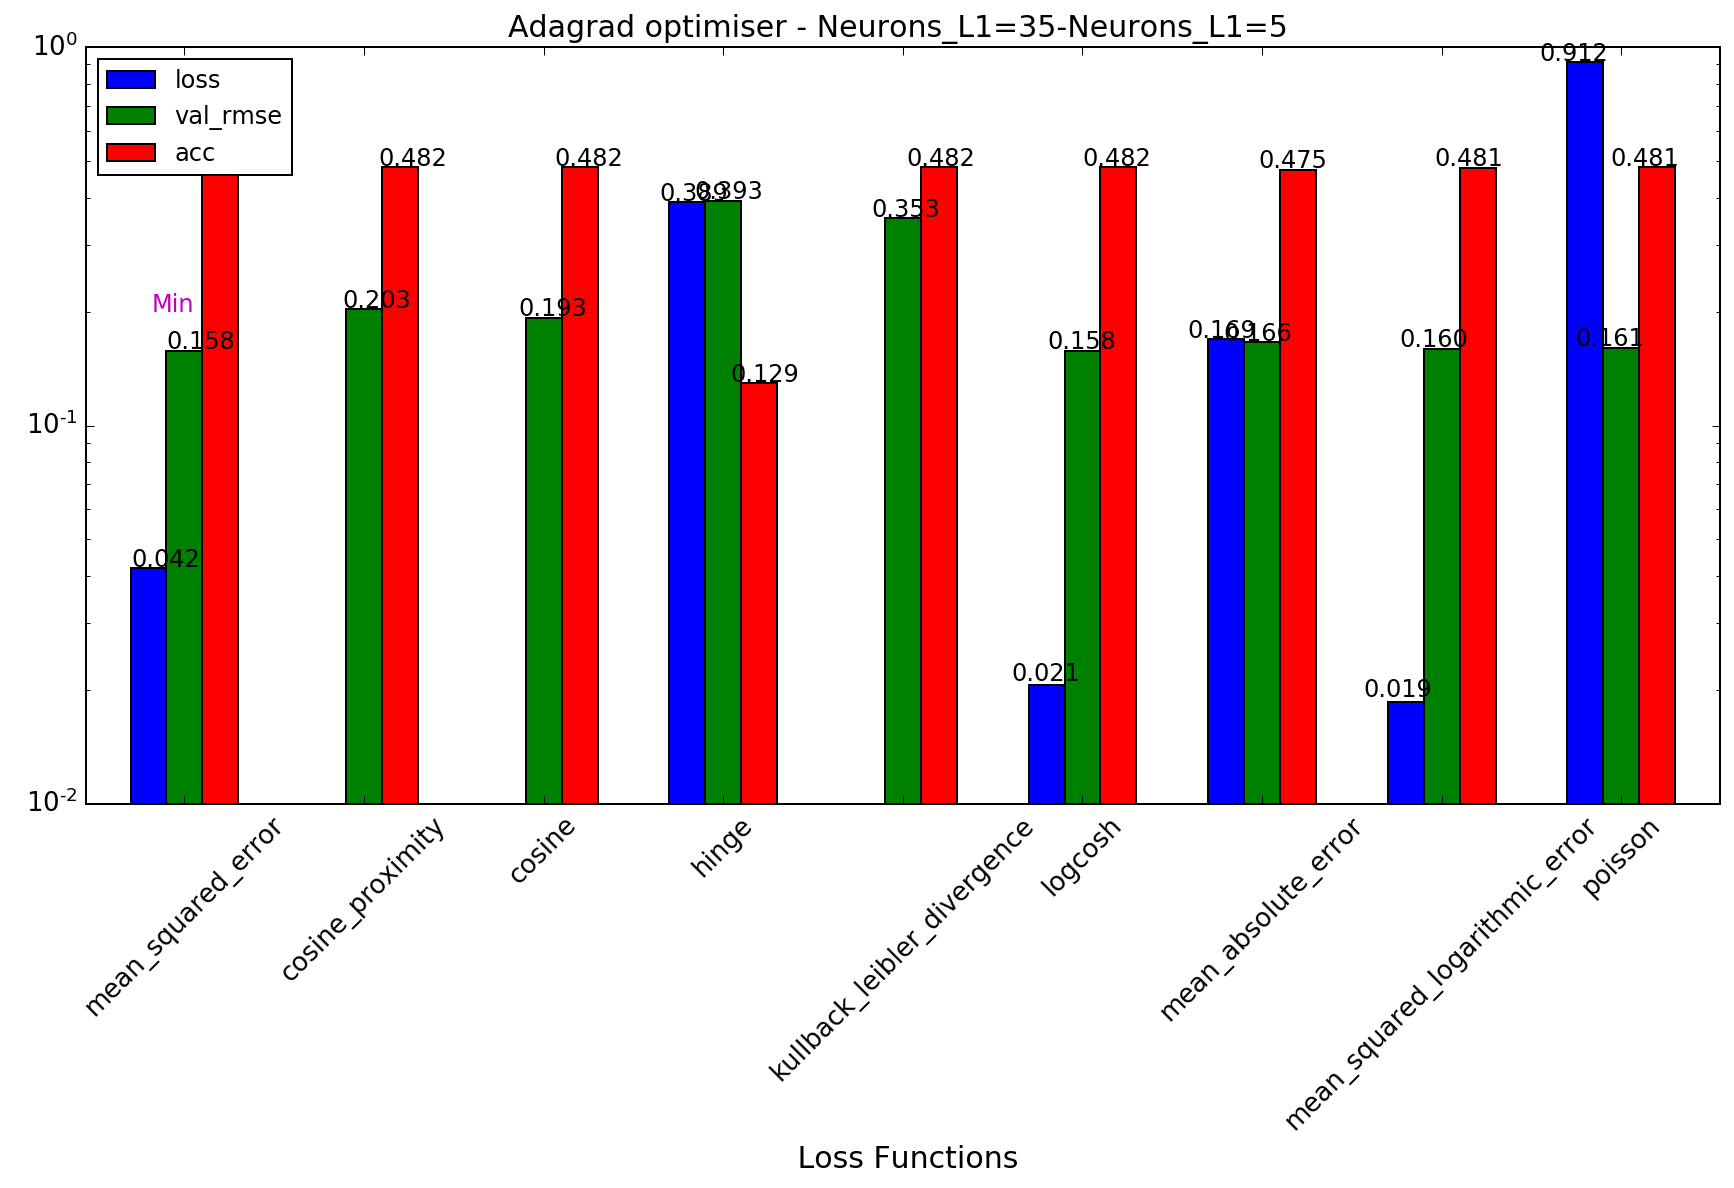

In [29]:
# plotting and saving the figure for Adagrad optimiser
# neurons_layer1= 35
# neurons_layer2= 15
# activation_layer1= sigmoid
# activation_layer2= sigmoid
# activation_dense_layer= relu
ax=y[(y["Optimiser"] =='Adagrad') & (y["Neurons_L1"] == 35)].plot(kind='bar',y=['loss','val_rmse','acc'],figsize=(12,8),subplots=False,grid=False,legend=True
                              ,logy=True,fontsize=10,width=0.60)
for p in ax.patches:
    valy = "{0:.3f}".format(round(p.get_height(),3))
    valx = "{0:.3f}".format(round(p.get_x(),3))
    
    ax.annotate(str(valy), (float(valx)*0.98 , float(valy) *1.0100),size=12)
plt.text(x=-0.18,y=0.20,s='Min',color='m',size=12)
plt.tight_layout()
plt.yticks(fontsize=13)
plt.xticks(rotation=45,fontsize=13)
plt.xlabel(' Loss Functions',fontsize=15)
#plt.ylabel('Performance Measure',fontsize=10)
plt.title('Adagrad optimiser - Neurons_L1=35-Neurons_L1=5 ',size=15)
plt.savefig('output_pm_adagrad-Neurons_L1=35-Neurons_L2=5.png')

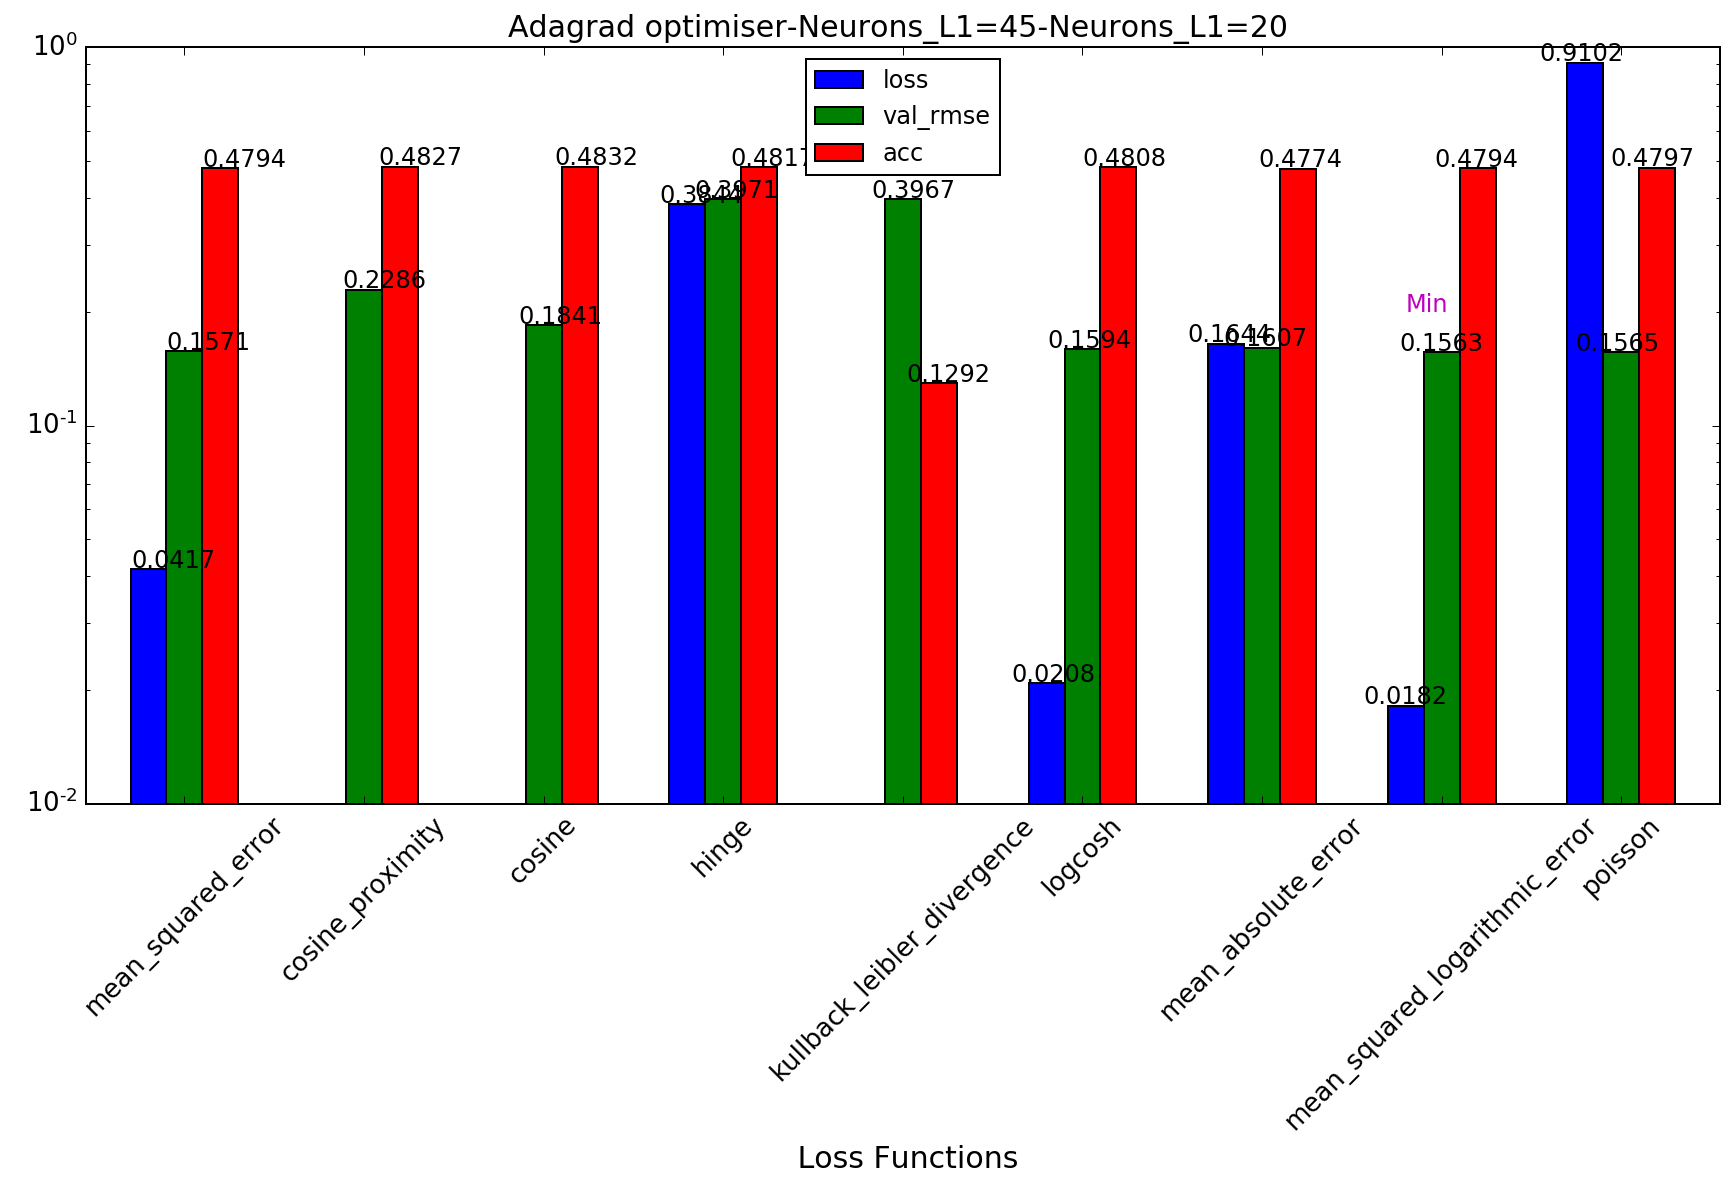

In [30]:
# plotting and saving the figure for Adagrad optimiser
# neurons_layer1= 35
# neurons_layer2= 15
# activation_layer1= sigmoid
# activation_layer2= sigmoid
# activation_dense_layer= relu
ax=y[(y["Optimiser"] =='Adagrad') & (y["Neurons_L1"] == 45)].plot(kind='bar',y=['loss','val_rmse','acc'],figsize=(12,8),subplots=False,grid=False,legend=True
                              ,logy=True,fontsize=10,width=0.60)
for p in ax.patches:
    valy = "{0:.4f}".format(round(p.get_height(),4))
    valx = "{0:.4f}".format(round(p.get_x(),4))
    
    ax.annotate(str(valy), (float(valx)*0.98 , float(valy) *1.0100),size=12)
plt.text(x=6.80,y=0.20,s='Min',color='m',size=12)
plt.tight_layout()
plt.yticks(fontsize=13)
plt.xticks(rotation=45,fontsize=13)
plt.xlabel(' Loss Functions',fontsize=15)
#plt.ylabel('Performance Measure',fontsize=10)
plt.title('Adagrad optimiser-Neurons_L1=45-Neurons_L1=20 ',size=15)
plt.savefig('output_pm_adagrad-Neurons_L1=45-Neurons_L2=20.png')

#sgd optimiser

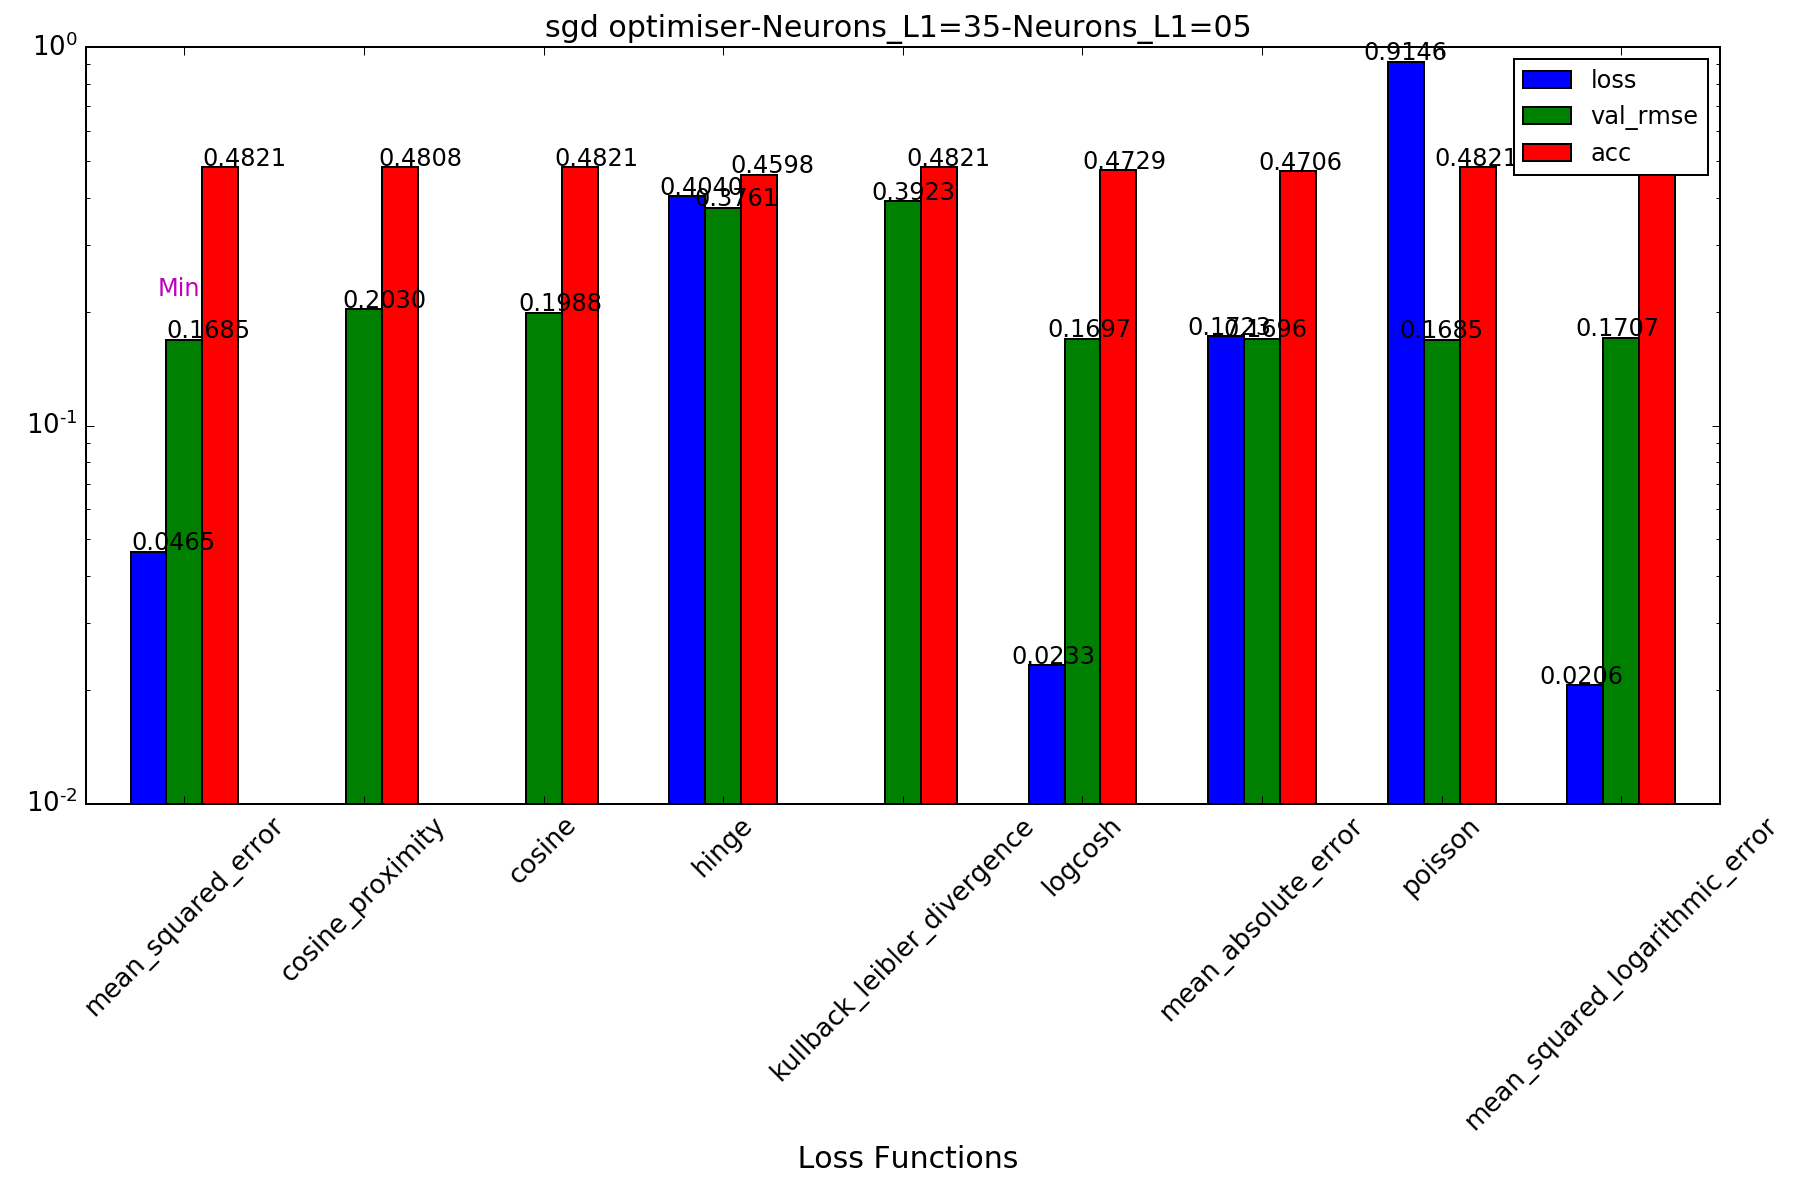

In [31]:
ax=y[(y["Optimiser"] =='sgd') & (y["Neurons_L1"] == 35)].plot(kind='bar',y=['loss','val_rmse','acc'],figsize=(12,8),subplots=False,grid=False,legend=True
                              ,logy=True,fontsize=10,width=0.60)
for p in ax.patches:
    valy = "{0:.4f}".format(round(p.get_height(),4))
    valx = "{0:.4f}".format(round(p.get_x(),4))
    
    ax.annotate(str(valy), (float(valx)*0.98 , float(valy) *1.0100),size=12)
plt.text(x=-0.15,y=0.22,s='Min',color='m',size=12)
plt.tight_layout()
plt.yticks(fontsize=13)
plt.xticks(rotation=45,fontsize=13)
plt.xlabel(' Loss Functions',fontsize=15)
#plt.ylabel('Performance Measure',fontsize=10)
plt.title('sgd optimiser-Neurons_L1=35-Neurons_L1=05 ',size=15)
plt.savefig('output_pm_sgd-Neurons_L1=35-Neurons_L2=5.png')

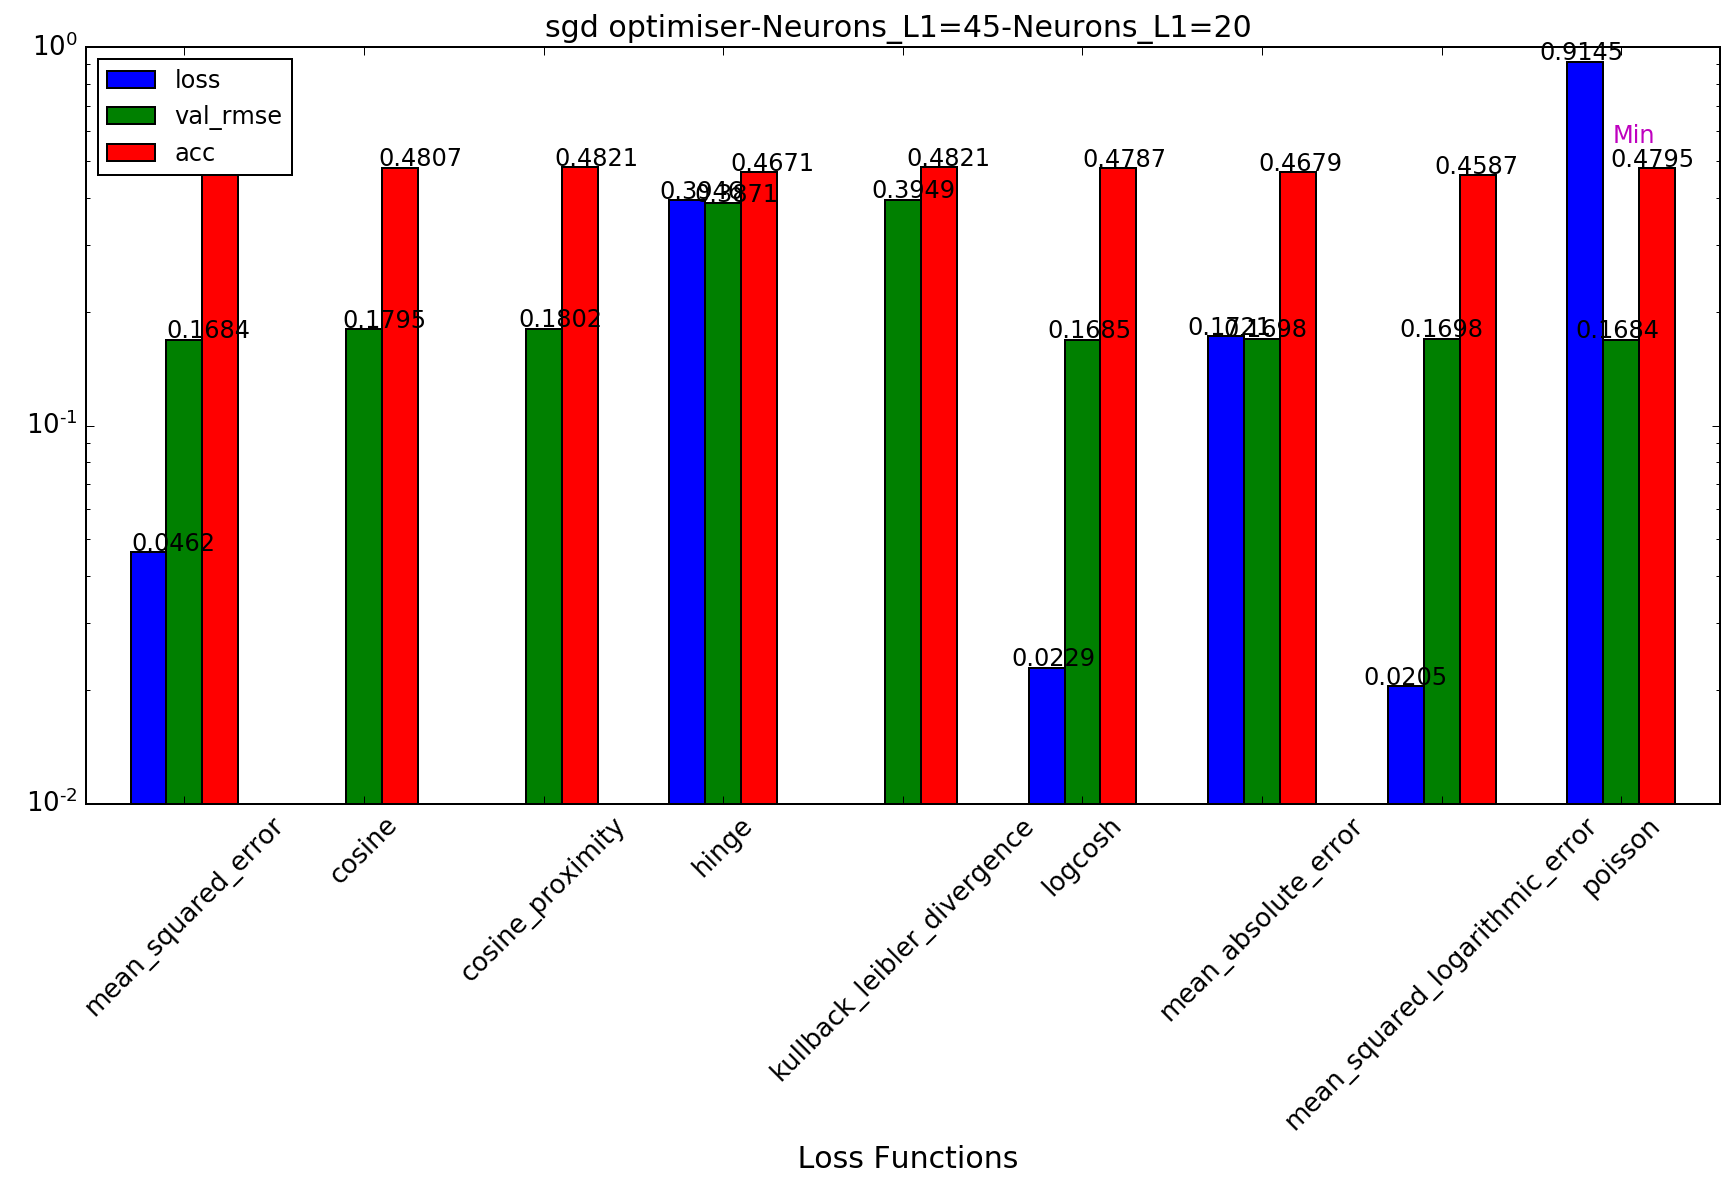

In [32]:
ax=y[(y["Optimiser"] =='sgd') & (y["Neurons_L1"] == 45)].plot(kind='bar',y=['loss','val_rmse','acc'],figsize=(12,8),subplots=False,grid=False,legend=True
                              ,logy=True,fontsize=10,width=0.60)
for p in ax.patches:
    valy = "{0:.4f}".format(round(p.get_height(),4))
    valx = "{0:.4f}".format(round(p.get_x(),4))
    
    ax.annotate(str(valy), (float(valx)*0.98 , float(valy) *1.0100),size=12)
plt.text(x=7.95,y=0.56,s='Min',color='m',size=12)
plt.tight_layout()
plt.yticks(fontsize=13)
plt.xticks(rotation=45,fontsize=13)
plt.xlabel(' Loss Functions',fontsize=15)
#plt.ylabel('Performance Measure',fontsize=10)
plt.title('sgd optimiser-Neurons_L1=45-Neurons_L1=20 ',size=15)
plt.savefig('output_pm_sgd-Neurons_L1=45-Neurons_L2=20.png')

#rmsprop optimiser

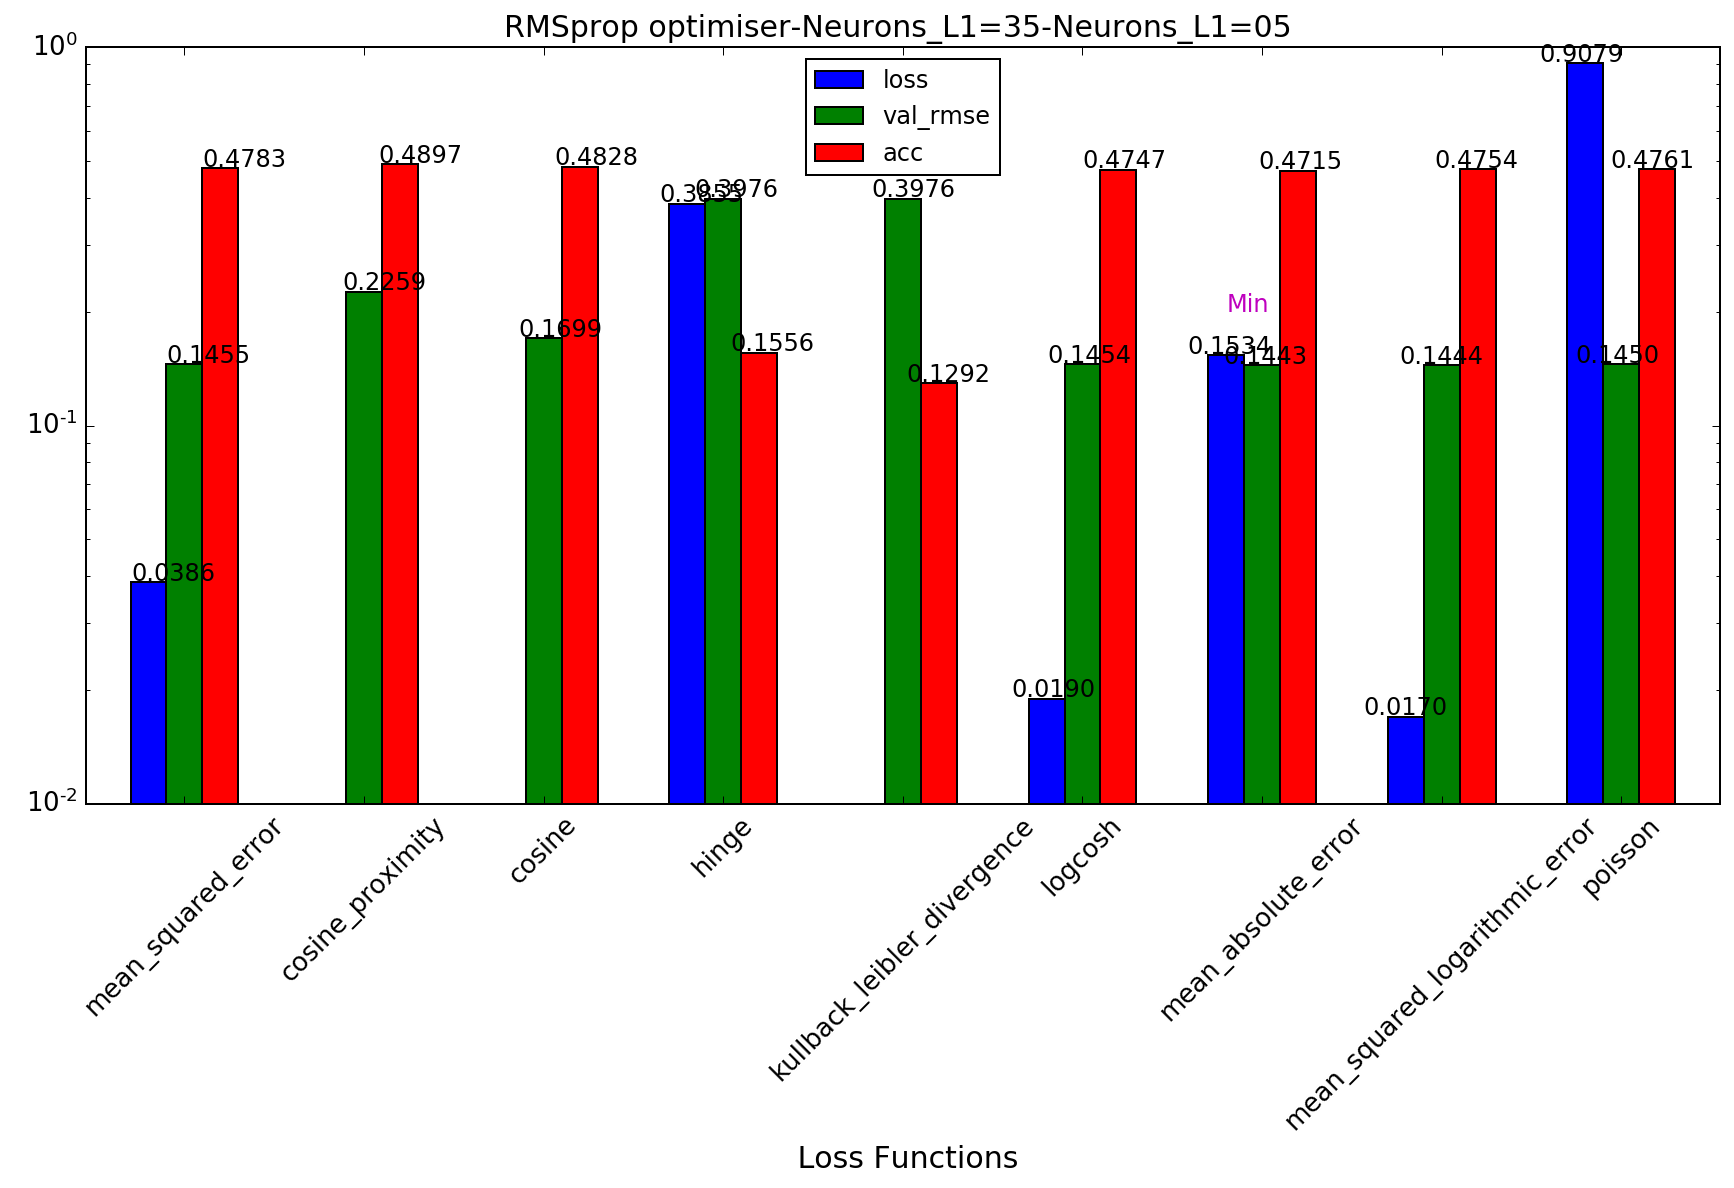

In [33]:
ax=y[(y["Optimiser"] =='RMSprop') & (y["Neurons_L1"] == 35)].plot(kind='bar',y=['loss','val_rmse','acc'],figsize=(12,8),subplots=False,grid=False,legend=True
                              ,logy=True,fontsize=10,width=0.60)
for p in ax.patches:
    valy = "{0:.4f}".format(round(p.get_height(),4))
    valx = "{0:.4f}".format(round(p.get_x(),4))
    
    ax.annotate(str(valy), (float(valx)*0.98 , float(valy) *1.0100),size=12)
plt.text(x=5.80,y=0.20,s='Min',color='m',size=12)
plt.tight_layout()
plt.yticks(fontsize=13)
plt.xticks(rotation=45,fontsize=13)
plt.xlabel(' Loss Functions',fontsize=15)
#plt.ylabel('Performance Measure',fontsize=10)
plt.title('RMSprop optimiser-Neurons_L1=35-Neurons_L1=05 ',size=15)
plt.savefig('output_pm_RMSprop-Neurons_L1=35-Neurons_L2=5.png')

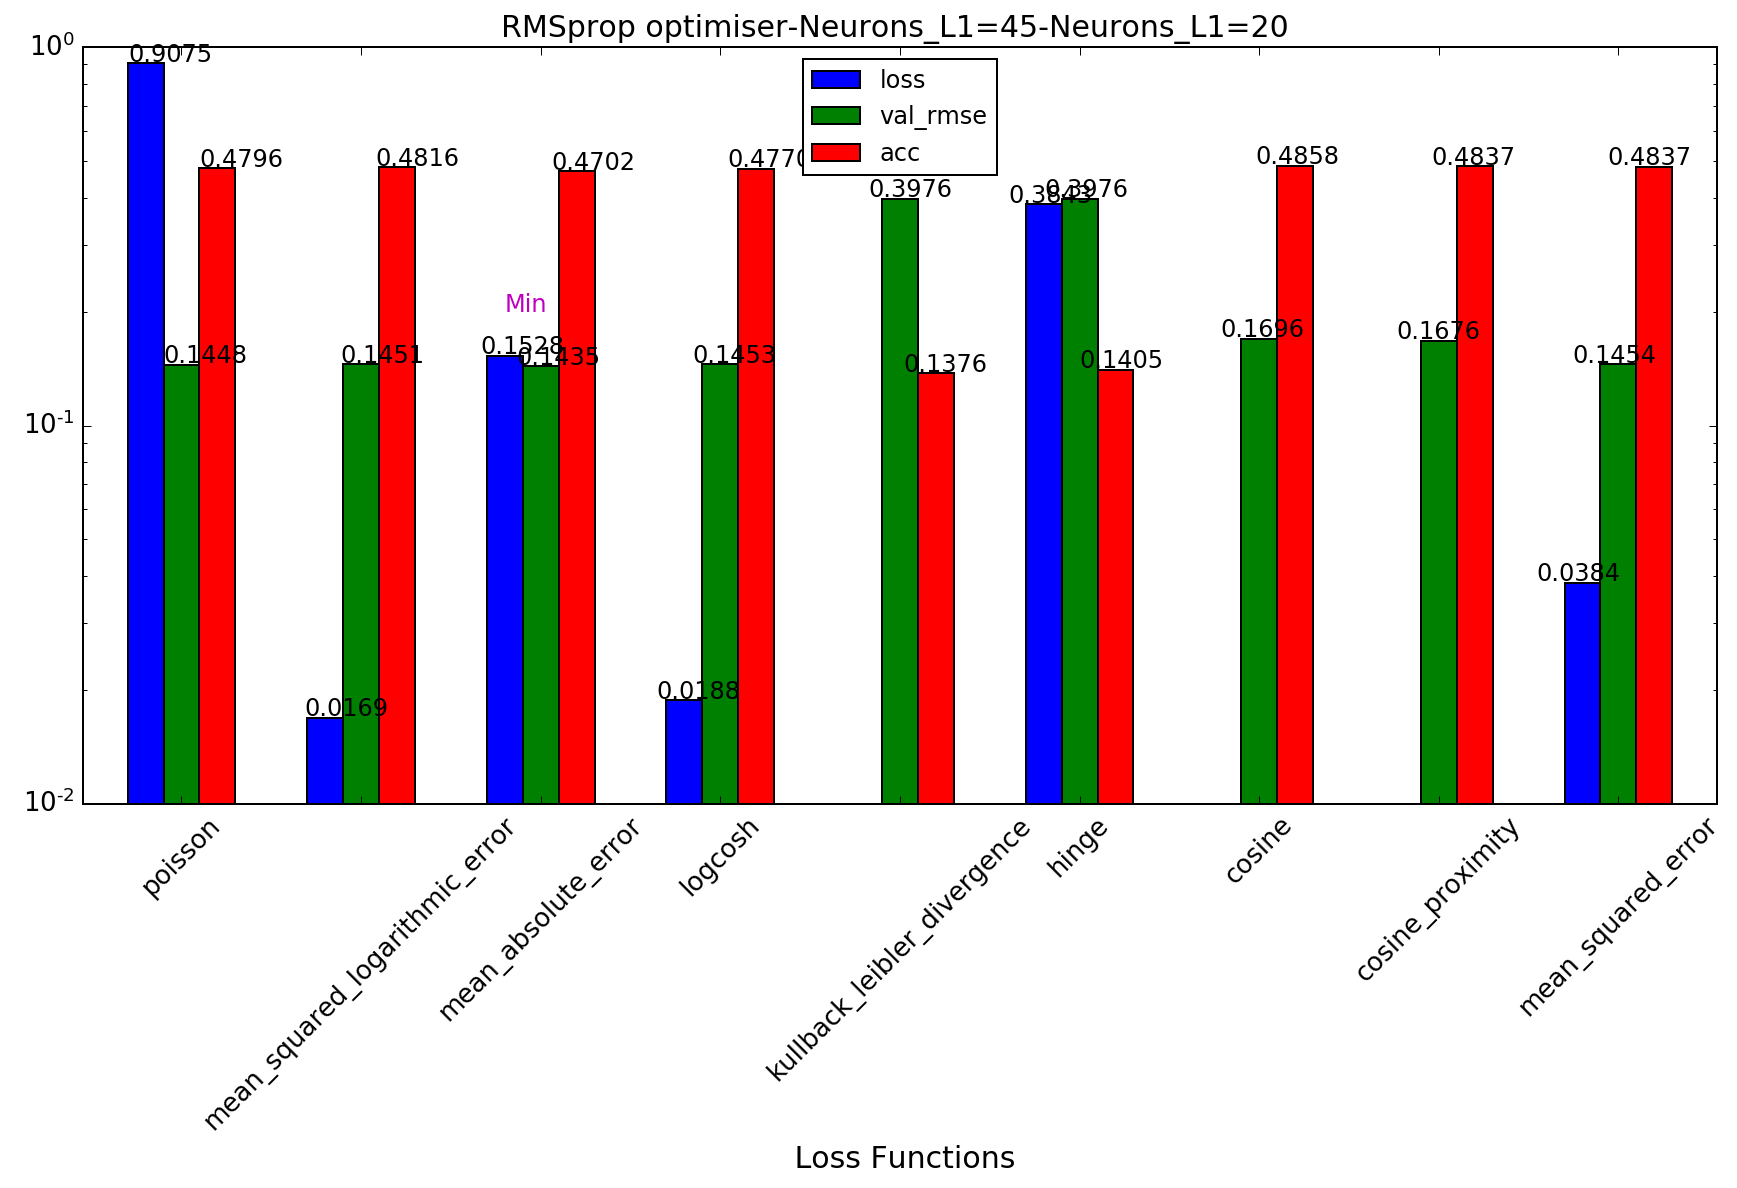

In [34]:
ax=y[(y["Optimiser"] =='RMSprop') & (y["Neurons_L1"] == 45)].plot(kind='bar',y=['loss','val_rmse','acc'],figsize=(12,8),subplots=False,grid=False,legend=True
                              ,logy=True,fontsize=10,width=0.60)
for p in ax.patches:
    valy = "{0:.4f}".format(round(p.get_height(),4))
    valx = "{0:.4f}".format(round(p.get_x(),4))
    
    ax.annotate(str(valy), (float(valx)*0.98 , float(valy) *1.0100),size=12)

plt.text(x=1.8,y=0.20,s='Min',color='m',size=12)
plt.tight_layout()
plt.yticks(fontsize=13)
plt.xticks(rotation=45,fontsize=13)
plt.xlabel(' Loss Functions',fontsize=15)
#plt.ylabel('Performance Measure',fontsize=10)
plt.title('RMSprop optimiser-Neurons_L1=45-Neurons_L1=20 ',size=15)
plt.savefig('output_pm_RMSprop-Neurons_L1=45-Neurons_L2=20.png')

#Best Performing optimiser two neuron configurations

In [ ]:
y[(y["Optimiser"] =='RMSprop') & (y["Neurons_L1"] == 35)]['val_rmse']==0.1443379315014566

In [ ]:
y[(y["Optimiser"] =='RMSprop') & (y["Neurons_L1"] == 45)]['val_rmse']==0.1435004122026111

In [ ]:
y[(y["Optimiser"] =='Adagrad') & (y["Neurons_L1"] == 35)]['val_rmse']==0.1576157681896241

In [ ]:
y[(y["Optimiser"] =='Adagrad') & (y["Neurons_L1"] == 45)]['val_rmse']==0.1563493382000613

In [ ]:
y[(y["Optimiser"] =='sgd') & (y["Neurons_L1"] == 35)]['val_rmse']==0.1685271531119213

In [ ]:
y[(y["Optimiser"] =='sgd') & (y["Neurons_L1"] == 45)]['val_rmse']==0.1683639100491686

In [ ]:
# Further exploring for the RMSprop as it shows the best accuracy on all 
# the above optimiser, so changing the range of the neurons and exploring for best parameters
# using cosine as the loss function for the same activation functions
# generating 3 iterations for each tunes parameter

# Running further tests on best Performing Optimiser with our Flow Data by manully inputting the system parameters

In [242]:
#rearranging the results dataframe columnwise-- copied the cell from above with addtional neurons and activation
# function logging.
z['Optimiser']=str(objective_function[2])
z['Epochs']=20
z['Neurons_L1']=int(neurons_considered_layer1[neurons_considered_layer1_index])
z['Neurons_L2']=int(neurons_considered_layer2[neurons_considered_layer2_index])
z['Avt_L1']='sigmoid'
z['Act_L2']='sigmoid'
z['Act_DL']='sigmoid'
z = z.reindex(columns=['loss','acc','rmse','val_rmse','val_loss','val_acc','Avt_L1','Neurons_L1','Act_L2',
                       'Neurons_L2','Epochs','Act_DL','Optimiser'])



In [243]:
z

,loss,acc,rmse,val_rmse,val_loss,val_acc,Avt_L1,Neurons_L1,Act_L2,Neurons_L2,Epochs,Act_DL,Optimiser
mean_absolute_error,0.152466,0.474414,0.160147,0.143117,0.136924,0.471275,sigmoid,65,sigmoid,20,20,sigmoid,RMSprop


In [244]:
#reading the excel sheet to append results
x=pd.read_excel('Results_Objective_Function_RMSprop_Analysis_latest.xlsx')
x=x.append(z)


In [245]:
# storing the results in an excel sheet to read
# and append again with changed model loss function
writer = pd.ExcelWriter('Results_Objective_Function_RMSprop_Analysis_latest.xlsx')

x.to_excel(writer,'Sheet1')
writer.save()

# Loading the Stored file to plot the individual results w.r.t the variable layer neurons used

In [298]:
#reading the excel sheet to read above stored results results
y=pd.read_excel('Results_Objective_Function_RMSprop_Analysis_latest.xlsx')

In [299]:
y.head()

,Act_DL,Act_L2,Avt_L1,Epochs,Neurons_L1,Neurons_L2,Optimiser,acc,loss,rmse,val_acc,val_loss,val_rmse
mean_absolute_error,sigmoid,sigmoid,sigmoid,20,35,3,RMSprop,0.464072,0.153061,0.160471,0.461751,0.137702,0.143839
mean_absolute_error,sigmoid,sigmoid,sigmoid,20,35,3,RMSprop,0.458900,0.153519,0.161005,0.448694,0.138296,0.144480
mean_absolute_error,sigmoid,sigmoid,sigmoid,20,35,3,RMSprop,0.455671,0.154072,0.162007,0.445699,0.139045,0.145575
mean_absolute_error,sigmoid,sigmoid,sigmoid,20,35,3,RMSprop,0.470031,0.153490,0.160938,0.471813,0.138075,0.144283
mean_absolute_error,sigmoid,sigmoid,sigmoid,20,35,5,RMSprop,0.477124,0.153112,0.160584,0.469892,0.138061,0.144225


In [338]:
y[y.val_rmse==np.min(y['val_rmse'])]

,Act_DL,Act_L2,Avt_L1,Epochs,Neurons_L1,Neurons_L2,Optimiser,acc,loss,rmse,val_acc,val_loss,val_rmse
mean_absolute_error,sigmoid,sigmoid,sigmoid,20,65,5,RMSprop,0.473068,0.152483,0.159882,0.471198,0.136462,0.14265


<generator object <genexpr> at 0x000002420A670E60>


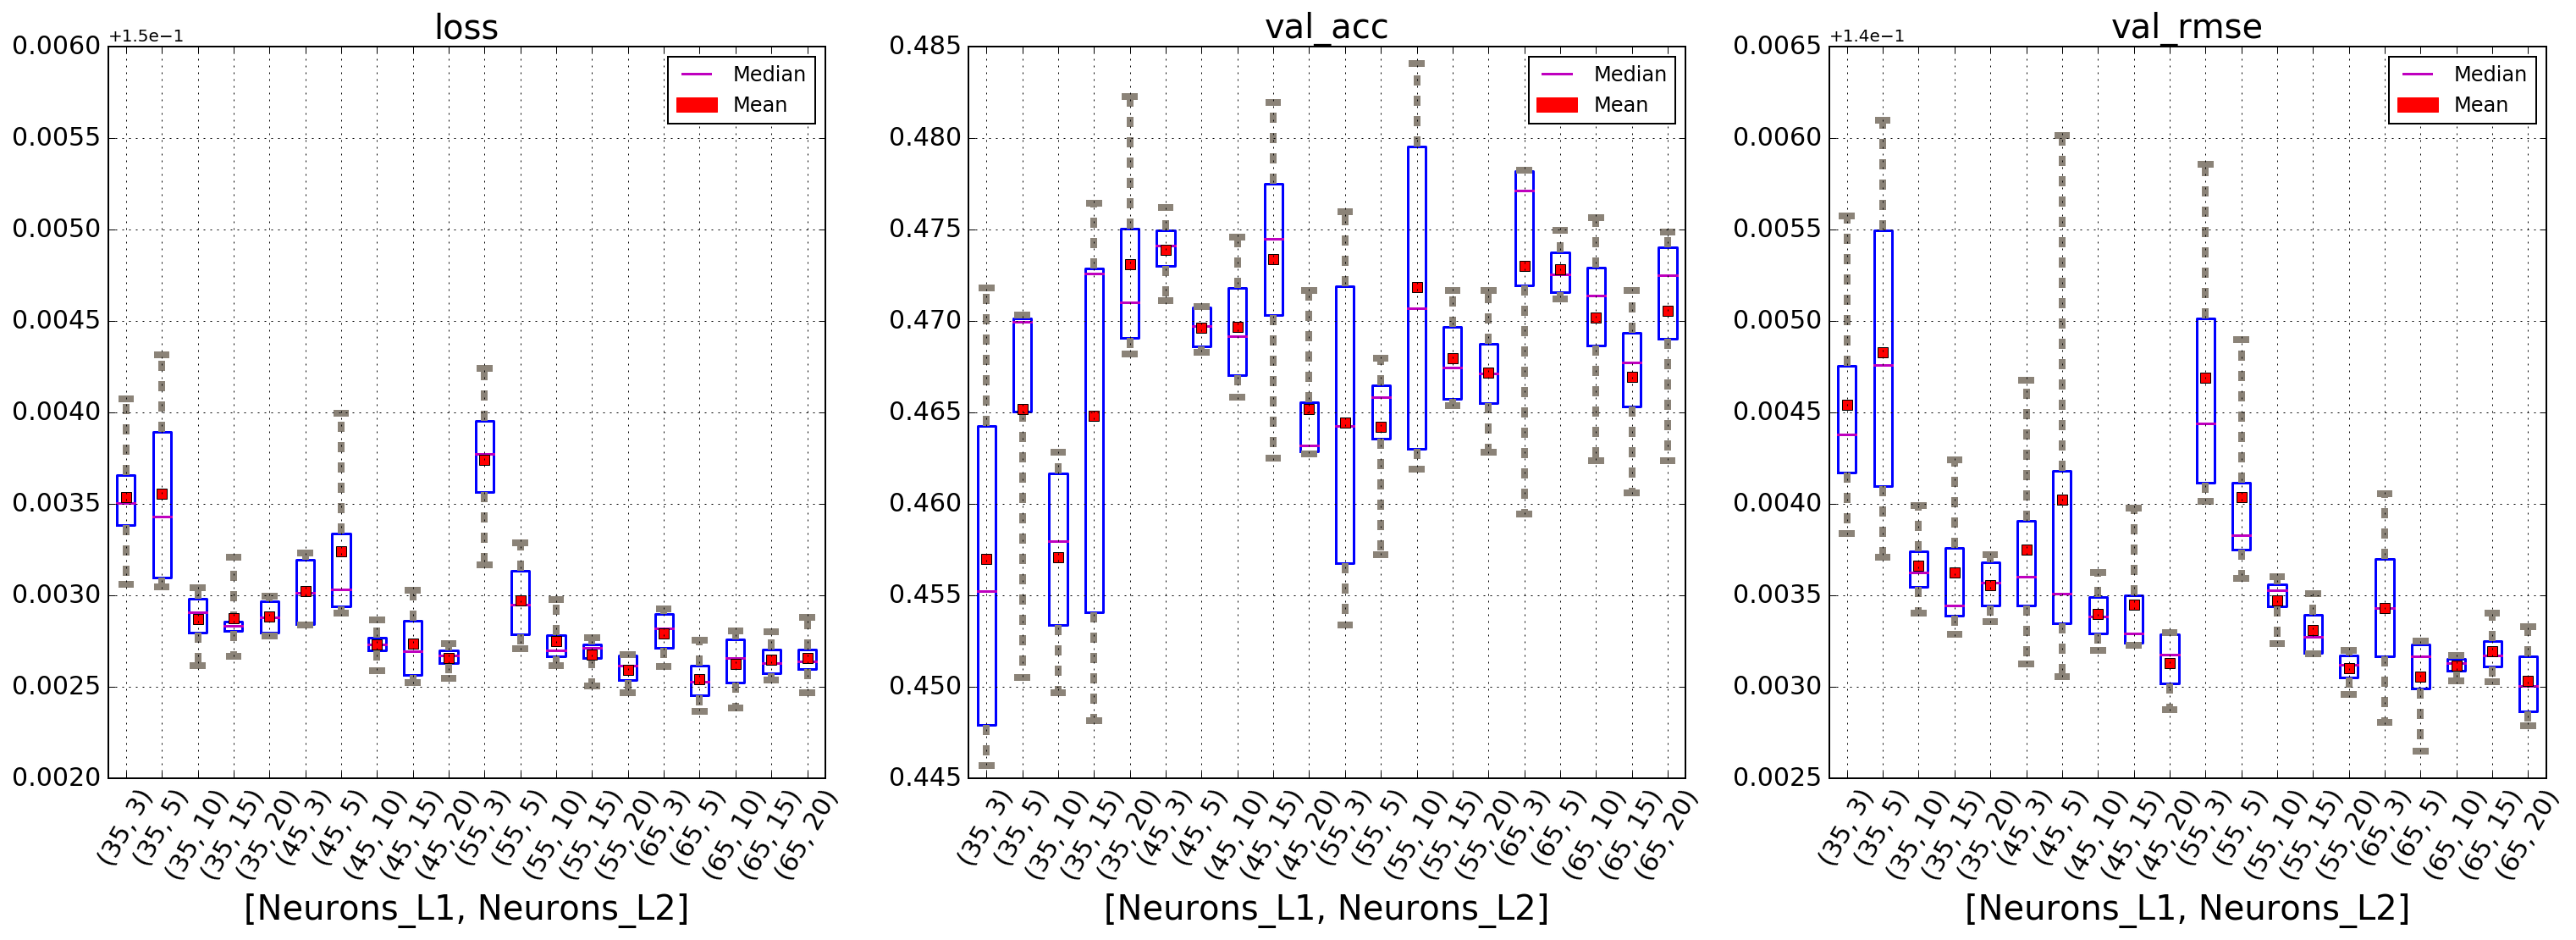

In [343]:
# plotting and saving the figure for with respect to neurons used in layer 1 and layer 2

# demonstrate how to customize the display different elements:
boxprops = dict(linestyle='-', linewidth=4, color='k')
medianprops = dict(linestyle='-', linewidth=4, color='k')

###########
medianprops = dict(linestyle='-', linewidth=4, color='k')
fig, ax_new = plt.subplots(1,3, sharey=False,sharex=True,figsize=(25,8))
bp=y.boxplot(column=['loss','val_acc','val_rmse'], by=['Neurons_L1','Neurons_L2'],rot=60,
         layout=(1,3),sym='', boxprops=boxprops, medianprops=medianprops, showmeans=True,whis='range',
                return_type='dict',ax=ax_new,fontsize=15 )
#ax_new[0].ylim[-1:1]
# boxplot style adjustments
[[item.set_linewidth(1.5) for item in bp[key]['boxes']] for key in bp.keys()]
[[item.set_linewidth(1.5) for item in bp[key]['fliers']] for key in bp.keys()]
[[item.set_linewidth(1.5) for item in bp[key]['medians']] for key in bp.keys()]
[[item.set_linewidth(0.5) for item in bp[key]['means']] for key in bp.keys()]
[[item.set_linewidth(4) for item in bp[key]['whiskers']] for key in bp.keys()]
[[item.set_linewidth(4) for item in bp[key]['caps']] for key in bp.keys()]

[[item.set_color('b') for item in bp[key]['boxes']] for key in bp.keys()]
# seems to have no effect
[[item.set_color('b') for item in bp[key]['fliers']] for key in bp.keys()]
[[item.set_color('m') for item in bp[key]['medians']] for key in bp.keys()]
[[item.set_markerfacecolor('r') for item in bp[key]['means']] for key in bp.keys()]
[[item.set_color('#8B8378') for item in bp[key]['whiskers']] for key in bp.keys()]
[[item.set_color('#8B8378') for item in bp[key]['caps']] for key in bp.keys()]



#plt.gca()

#chaniging the individual graph  tital font sizes to make it more readable
ax_new[0].title.set_size(20)
ax_new[1].title.set_size(20)
ax_new[2].title.set_size(20)

#chaniging the x labels font size to make it more readable
ax_new[0].xaxis.label.set_size(20)
ax_new[1].xaxis.label.set_size(20)
ax_new[2].xaxis.label.set_size(20)

#chaniging the ylimit for loss graph to make it more readable
ax_new[0].set_ylim([-1.2,+1])

#eliminating the auto generated plot label
fig.suptitle('')

# Adding a custom legend for the means and median
legend_elements = [Line2D([0], [0], color='m', lw=1.5, label='Median'),
                   Patch(facecolor='red', edgecolor='r',
                         label='Mean',lw=0.5)]

ax_new[0].legend(handles=legend_elements, loc='best')
ax_new[1].legend(handles=legend_elements, loc='best')
ax_new[2].legend(handles=legend_elements, loc='best')


ax_new[0].set_ylim([0.1520,0.1560])
ax_new[2].
#plt.xlabel(' Loss Functions')
#plt.ylabel('Performance Measure')
#plt.title('Graph showing Adagrad used as optimiser with  loss functions',size=15)
plt.savefig('output_pm_vs_Neuron_layer1_Neuron_layer2.png', bbox_inches='tight')

# Running further tests on best Performing [Neurons_L1,Neurons_L2] with our Flow Data by chanign the layer 1 and layer 2 activation function

In [452]:
#rearranging the results dataframe columnwise-- copied the cell from above with addtional neurons and activation
# function logging.
# from above boxplots we figured out the best performing neuron layer pair as (35,5)
# reason beng the greated exhibited mean accuracy compared to other althoug the val rmse is
# a bit high comapared to other pairs but we have to make sure that the network doesnot overfit the data
# so on the other hand loss funciton mean is also reasonable low with respect to performance accuarcy when compared
#other neuron pairs.

#z DataFrame is coming from machine learning history model
z['Optimiser']=str(objective_function[2])
z['Epochs']=20
z['Neurons_L1']=int(neurons_considered_layer1[neurons_considered_layer1_index])
z['Neurons_L2']=int(neurons_considered_layer2[neurons_considered_layer2_index])

# for activaion function we conidered all the regression prediction acitvation functions as reported by literature.
# apart from the one specifically used for classification as our's is a regression problem.
#original test were performaed with signoid and relu in (L2,L2) and D_l repsectively
# we consider in our case as sigmoid,tanh, linear, elu, softmax,leaky_relu,scaled_exponential,exponential_linear_unit
# by deafult hard_sigmoid on return sequences
# 4 iterations for each configuration
z['Avt_L1']=possible_combinations[activation_index][0]
z['Act_L2']=possible_combinations[activation_index][1]
z['Act_DL']=possible_combinations[activation_index][2]
z = z.reindex(columns=['loss','acc','rmse','val_rmse','val_loss','val_acc','Avt_L1','Neurons_L1','Act_L2',
                       'Neurons_L2','Epochs','Act_DL','Optimiser'])

In [453]:
z

,loss,acc,rmse,val_rmse,val_loss,val_acc,Avt_L1,Neurons_L1,Act_L2,Neurons_L2,Epochs,Act_DL,Optimiser
mean_absolute_error,0.470152,0.129181,0.534068,0.520128,0.459016,0.136713,relu,65,relu,5,20,relu,RMSprop


In [454]:
#reading the excel sheet to append results
x=pd.read_excel('Results_Objective_Function_Activ_function__Analysis(softmax_sigmoid)_latest.xlsx')
x=x.append(z)


In [455]:
# storing the results in an excel sheet to read
# and append again with changed model loss function
writer = pd.ExcelWriter('Results_Objective_Function_Activ_function__Analysis(softmax_sigmoid)_latest.xlsx')

x.to_excel(writer,'Sheet1')
writer.save()

# Loading the Stored file to plot the  results w.r.t the Activation Functions

In [13]:
#reading the excel sheet to read above stored results results
file_list=['Results_Objective_Function_Activ_function__Analysis(sigmoid_relu)_latest.xlsx',
           'Results_Objective_Function_Activ_function__Analysis(sigmoid_tanh)_latest.xlsx',
           'Results_Objective_Function_Activ_function__Analysis(softmax_relu)_latest.xlsx',
          'Results_Objective_Function_Activ_function__Analysis(softmax_sigmoid)_latest.xlsx',
           'Results_Objective_Function_Activ_function__Analysis(softmax_tanh)_latest.xlsx',
           'Results_Objective_Function_Activ_function__Analysis(tanh_relu)_latest.xlsx']


In [14]:
Y1=pd.read_excel('Results_Objective_Function_Activ_function__Analysis(sigmoid_relu)_latest.xlsx')
Y2=pd.read_excel('Results_Objective_Function_Activ_function__Analysis(sigmoid_tanh)_latest.xlsx')
Y3=pd.read_excel('Results_Objective_Function_Activ_function__Analysis(softmax_relu)_latest.xlsx')
Y4=pd.read_excel('Results_Objective_Function_Activ_function__Analysis(softmax_sigmoid)_latest.xlsx')
Y5=pd.read_excel('Results_Objective_Function_Activ_function__Analysis(softmax_tanh)_latest.xlsx')
Y6=pd.read_excel('Results_Objective_Function_Activ_function__Analysis(tanh_relu)_latest.xlsx')

In [15]:
frames = [Y1, Y2,Y3,Y4,Y5,Y6]
y = pd.concat(frames)

,Act_DL,Act_L2,Avt_L1,Epochs,Neurons_L1,Neurons_L2,Optimiser,acc,loss,rmse,val_acc,val_loss,val_rmse
mean_absolute_error,sigmoid,sigmoid,sigmoid,20,65,5,RMSprop,0.472472,0.152547,0.159992,0.468433,0.136844,0.143050
mean_absolute_error,relu,sigmoid,sigmoid,20,65,5,RMSprop,0.129181,0.616373,0.624154,0.136713,0.606200,0.609041
mean_absolute_error,sigmoid,relu,sigmoid,20,65,5,RMSprop,0.462149,0.153549,0.162308,0.446006,0.138715,0.145779
mean_absolute_error,relu,relu,sigmoid,20,65,5,RMSprop,0.481988,0.298987,0.385028,0.484562,0.283340,0.367569
mean_absolute_error,sigmoid,sigmoid,relu,20,65,5,RMSprop,0.484160,0.151199,0.158674,0.478571,0.135835,0.142013
mean_absolute_error,relu,sigmoid,relu,20,65,5,RMSprop,0.483045,0.170962,0.182232,0.464900,0.151238,0.160090
mean_absolute_error,sigmoid,relu,relu,20,65,5,RMSprop,0.462534,0.151364,0.158846,0.448541,0.135840,0.142006
mean_absolute_error,relu,relu,relu,20,65,5,RMSprop,0.453326,0.303138,0.395389,0.474808,0.294674,0.386325
mean_absolute_error,sigmoid,sigmoid,sigmoid,20,65,5,RMSprop,0.473260,0.152527,0.159912,0.475883,0.136667,0.142798
mean_absolute_error,tanh,sigmoid,sigmoid,20,65,5,RMSprop,0.475106,0.152559,0.160440,0.471966,0.137090,0.143490


limit_output extension: Maximum message size of 10000 exceeded with 16883 characters

In [50]:
y1=y.set_index(['Avt_L1','Act_L2','Act_DL'])

In [53]:
y1=y1.filter(items=['val_rmse','val_acc'])

In [54]:
y1 = y1[~y1.index.duplicated(keep='first')]

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5]), <a list of 34 Text yticklabel objects>)

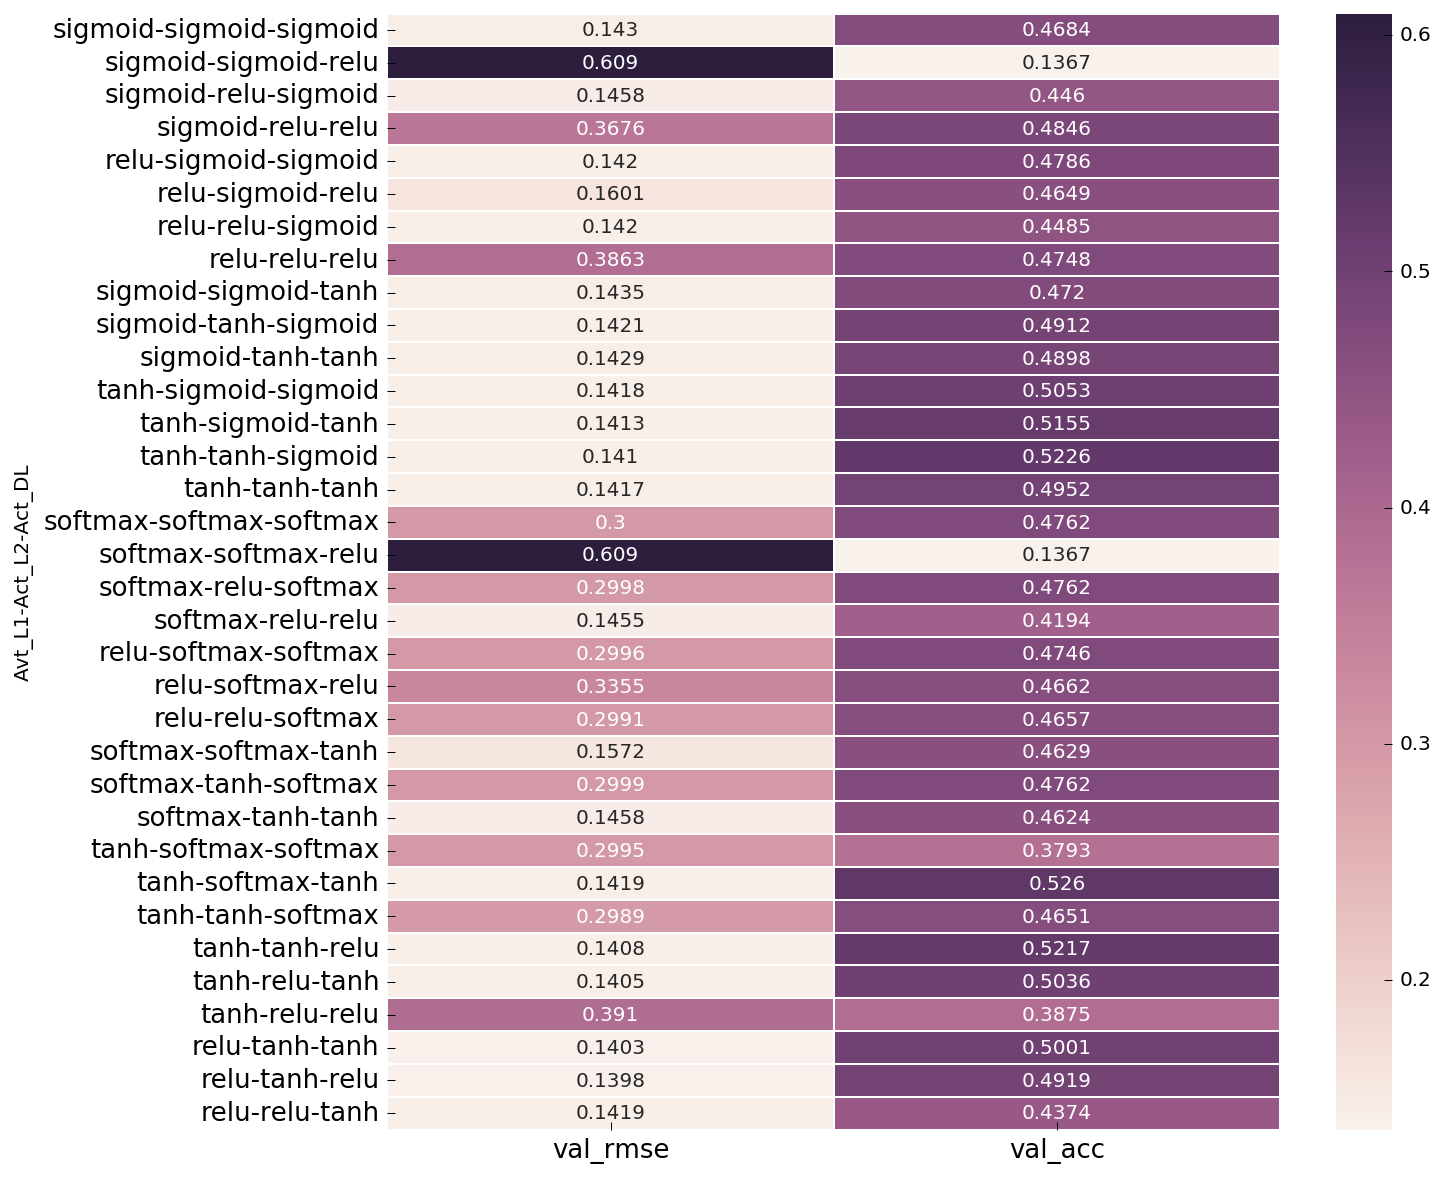

In [81]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(y1,annot=True,ax=ax,linewidths=0.5,fmt='.4g')
fig.savefig('output_activationfunction_pm_RMSprop_Neurons_L1=65_Neurons_L2=5.png',dpi=200, bbox_inches='tight', pad_inches=0.5, facecolor='white')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)